In [548]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mode
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import re
from xgboost import XGBClassifier


In [549]:
df_train = pd.read_excel('2018H1B_train.xlsx')

In [550]:
#data cleaning (dropping some useless variables by intuition lots of them has a lot of missing values which means these are not the request blanks
#for applicants to fill in.)

df_train_clean = df_train.drop(['CASE_NUMBER','EMPLOYER_NAME','EMPLOYER_BUSINESS_DBA','EMPLOYER_ADDRESS','EMPLOYER_PHONE',
                               'EMPLOYER_PHONE_EXT','AGENT_ATTORNEY_NAME','PUBLIC_DISCLOSURE_LOCATION','EMPLOYER_PROVINCE',
                               'AGENT_ATTORNEY_CITY','AGENT_ATTORNEY_STATE','WAGE_RATE_OF_PAY_TO','WAGE_RATE_OF_PAY_FROM','WORKSITE_POSTAL_CODE'
                               ,'SOC_NAME','JOB_TITLE'], axis=1)

df_train_clean.head()

,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_POSTAL_CODE,EMPLOYER_COUNTRY,...,PW_SOURCE_OTHER,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,ORIGINAL_CERT_DATE
0,CERTIFIED,2018-01-29,2018-02-02,H-1B,2018-07-28,2021-07-27,REDMOND,WA,98052,UNITED STATES OF AMERICA,...,OFLC ONLINE DATA CENTER,Year,N,N,NaN,NaN,REDMOND,KING,WA,NaT
1,CERTIFIED,2017-10-23,2017-10-27,H-1B,2017-11-06,2020-11-06,SECAUCUS,NJ,07094,UNITED STATES OF AMERICA,...,OFLC ONLINE DATA CENTER,Year,N,N,NaN,NaN,SANTA CLARA,SAN JOSE,CA,NaT
2,CERTIFIED,2018-08-30,2018-09-06,H-1B,2018-09-10,2021-09-09,IRVING,TX,75062,UNITED STATES OF AMERICA,...,OFLC ONLINE DATA CENTER,Year,N,N,NaN,NaN,IRVING,DALLAS,TX,NaT
3,CERTIFIED,2018-08-31,2018-09-07,H-1B,2018-09-07,2021-09-06,ISELIN,NJ,08830,UNITED STATES OF AMERICA,...,OFLC ONLINE DATA CENTER,Year,Y,N,Y,Y,BIRMINGHAM,SHELBY,AL,NaT
4,CERTIFIED,2018-05-22,2018-05-29,H-1B,2018-05-29,2021-05-28,IRVING,TX,75038,UNITED STATES OF AMERICA,...,OFLC ONLINE DATA CENTER,Year,Y,N,Y,NaN,SUNRISE,BROWARD,FL,NaT


In [551]:
#check the case status and since we are aiming predict accept or reject so we re-classifier the status
df_train_clean['CASE_STATUS'].value_counts()

#binary the result and drop "withdrawn" situation
binary_result = {"CASE_STATUS":       {"CERTIFIED": 1, "CERTIFIED-WITHDRAWN": 1, "DENIED":0}}
df_train_clean.replace(binary_result, inplace=True)
df_train_clean = df_train_clean[df_train_clean.CASE_STATUS != "WITHDRAWN"]

In [552]:
#continuing data clearning

# keep first two characters of SOC_CODE
df_train_clean['SOC_CODE'] = df_train_clean['SOC_CODE'].astype(str).str[:2]

#blank situation change to unknown
df_train_clean.PW_WAGE_LEVEL.replace(np.nan, 'Unknown',inplace=True)
df_train_clean.PW_SOURCE_OTHER.replace(np.nan, 'None',inplace=True)
df_train_clean.H1B_DEPENDENT.replace(np.nan, 'Unknown',inplace=True)
df_train_clean.WILLFUL_VIOLATOR.replace(np.nan, 'Unknown',inplace=True)
df_train_clean.SUPPORT_H1B.replace(np.nan, 'Unknown',inplace=True)
df_train_clean.LABOR_CON_AGREE.replace(np.nan, 'Unknown',inplace=True)

In [553]:
#drop rows with blank wage or 0 wage
df_train_clean = df_train_clean[df_train_clean.PREVAILING_WAGE != np.nan]
df_train_clean = df_train_clean[df_train_clean.PREVAILING_WAGE != 0]
df_train_clean1 = df_train_clean
df_train_clean1['PREVAILING_WAGE'].astype(float)

0         112549.00
1          79976.00
2          77792.00
3          87714.00
4          71864.00
5          92331.00
6          80579.00
7          88317.00
8         104790.00
9         109325.00
10         82638.00
11         69701.00
12         65707.00
13            30.97
14         65999.00
15         81780.00
16         50700.00
17            17.90
18            23.68
19         67879.00
20         58597.00
21        126539.00
22        110287.00
23        123363.00
24         75046.00
25         56784.00
26         75717.00
27         53000.00
28        125000.00
29        116802.00
            ...    
654247     93475.00
654248     96658.00
654249        49.85
654250     68390.00
654251     82326.00
654252     49462.00
654253     71614.00
654254    112320.00
654255    150675.00
654256     92810.00
654257     49795.00
654258     67246.00
654259     69014.00
654260     39978.00
654261     87173.00
654262     45781.00
654263     86653.00
654264     78624.00
654265     65541.00


In [554]:
#turn all wages into same unit and then drop unit of pay column
df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Hour', 'PREVAILING_WAGE'] = df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Hour','PREVAILING_WAGE']*34.4*365/7
df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Week', 'PREVAILING_WAGE'] = df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Week','PREVAILING_WAGE']*365/7
df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Month', 'PREVAILING_WAGE'] = df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Month','PREVAILING_WAGE']*12
df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Bi-Weekly', 'PREVAILING_WAGE'] = df_train_clean1.loc[df_train_clean1.PW_UNIT_OF_PAY == 'Bi-Weekly','PREVAILING_WAGE']*365/14

In [555]:
# Convert the date into a number (of days since some point)
df_train_clean2 = df_train_clean
fromDate1 = min(df_train_clean2['CASE_SUBMITTED'])
df_train_clean2['CASE_SUBMITTED'] = (df_train_clean2['CASE_SUBMITTED'] - fromDate1).dt.days.astype(int)

fromDate2 = min(df_train_clean2['DECISION_DATE'])
df_train_clean2['DECISION_DATE'] = (df_train_clean2['DECISION_DATE'] - fromDate2).dt.days.astype(int)

fromDate3 = min(df_train_clean2['EMPLOYMENT_START_DATE'])
df_train_clean2['EMPLOYMENT_START_DATE'] = (df_train_clean2['EMPLOYMENT_START_DATE'] - fromDate3).dt.days.astype(int)

fromDate4 = min(df_train_clean2['EMPLOYMENT_END_DATE'])
df_train_clean2['EMPLOYMENT_END_DATE'] = (df_train_clean2['EMPLOYMENT_END_DATE'] - fromDate4).dt.days.astype(int)

In [556]:
##to check the percentile in wages
print(np.nanpercentile(df_train_clean2.PREVAILING_WAGE,99.95))
df_train_clean2.PREVAILING_WAGE.median()

291970.0


81266.0

In [557]:
## replacing min and max with 99.95percentail
df_train_clean2.loc[df_train_clean2['PREVAILING_WAGE'] > 291970.0, 'PREVAILING_WAGE']= 81266.0
df_train_clean2.PREVAILING_WAGE.fillna(df_train_clean2.PREVAILING_WAGE.mean(), inplace = True)

In [558]:
# check the range of wage
df_train_clean2.groupby("PREVAILING_WAGE").size()

PREVAILING_WAGE
4500.000000      1
6413.571429      1
11000.000000     1
13004.428571     6
13022.365714     7
13542.542857     5
13632.228571     1
14170.342857     2
14349.714286     2
14618.771429     1
14654.645714     1
14780.205714     3
15031.325714     1
15147.000000     1
15246.571429     3
15504.000000     1
15514.000000     1
15515.628571     1
15547.000000     1
15650.000000     1
15695.000000     2
15712.937143     1
15748.811429     3
15910.245714     1
15928.182857     1
15946.120000     1
16017.868571     1
16053.742857     2
16143.428571     2
16538.045714     1
                ..
284045.000000    1
284170.000000    1
284274.000000    1
284378.000000    1
284419.000000    1
284731.000000    4
285106.000000    1
285189.000000    1
285293.000000    4
285480.000000    1
285646.000000    1
285958.000000    3
286000.000000    1
286998.000000    4
287462.000000    1
287498.000000    2
287518.000000    1
287560.000000    1
287602.000000    1
287643.000000    1
288184.000000  

In [560]:
# convert all the str variable into numerical verison
from sklearn.preprocessing import LabelEncoder
df_train_clean2["VISA_CLASS"]=LabelEncoder().fit_transform(df_train_clean2["VISA_CLASS"])
df_train_clean2["EMPLOYER_STATE"]=LabelEncoder().fit_transform(df_train_clean2["EMPLOYER_STATE"].astype(str))
df_train_clean2["EMPLOYER_CITY"]=LabelEncoder().fit_transform(df_train_clean2["EMPLOYER_CITY"].astype(str))
df_train_clean2["EMPLOYER_POSTAL_CODE"]=LabelEncoder().fit_transform(df_train_clean2["EMPLOYER_POSTAL_CODE"].astype(str))
df_train_clean2["EMPLOYER_COUNTRY"]=LabelEncoder().fit_transform(df_train_clean2["EMPLOYER_COUNTRY"])
df_train_clean2["AGENT_REPRESENTING_EMPLOYER"]=LabelEncoder().fit_transform(df_train_clean2["AGENT_REPRESENTING_EMPLOYER"].astype(str))
df_train_clean2["SOC_CODE"]=LabelEncoder().fit_transform(df_train_clean2["SOC_CODE"])
df_train_clean2["WAGE_UNIT_OF_PAY"]=LabelEncoder().fit_transform(df_train_clean2["WAGE_UNIT_OF_PAY"].astype(str))
df_train_clean2["PW_UNIT_OF_PAY"]=LabelEncoder().fit_transform(df_train_clean2["PW_UNIT_OF_PAY"].astype(str))
df_train_clean2["PW_WAGE_LEVEL"]=LabelEncoder().fit_transform(df_train_clean2["PW_WAGE_LEVEL"].astype(str))
df_train_clean2["PW_SOURCE"]=LabelEncoder().fit_transform(df_train_clean2["PW_SOURCE"].astype(str))
df_train_clean2["PW_SOURCE_YEAR"]=LabelEncoder().fit_transform(df_train_clean2["PW_SOURCE_YEAR"].astype(str))
df_train_clean2["PW_SOURCE_OTHER"]=LabelEncoder().fit_transform(df_train_clean2["PW_SOURCE_OTHER"].astype(str))
df_train_clean2["H1B_DEPENDENT"]=LabelEncoder().fit_transform(df_train_clean2["H1B_DEPENDENT"].astype(str))
df_train_clean2["WILLFUL_VIOLATOR"]=LabelEncoder().fit_transform(df_train_clean2["WILLFUL_VIOLATOR"].astype(str))
df_train_clean2["SUPPORT_H1B"]=LabelEncoder().fit_transform(df_train_clean2["SUPPORT_H1B"].astype(str))
df_train_clean2["LABOR_CON_AGREE"]=LabelEncoder().fit_transform(df_train_clean2["LABOR_CON_AGREE"].astype(str))
df_train_clean2["WORKSITE_CITY"]=LabelEncoder().fit_transform(df_train_clean2["WORKSITE_CITY"].astype(str))
df_train_clean2["WORKSITE_COUNTY"]=LabelEncoder().fit_transform(df_train_clean2["WORKSITE_COUNTY"].astype(str))
df_train_clean2["WORKSITE_STATE"]=LabelEncoder().fit_transform(df_train_clean2["WORKSITE_STATE"].astype(str))
df1 = df_train_clean2.copy()


In [562]:
#Now we start run some basic models such as logistic and linear regression to determine drop some useless variables

# set a threshold by using logistic regression and then dropping these columns
df1 = df1.drop('ORIGINAL_CERT_DATE', axis = 1)
df1 = df1.drop('WORKSITE_COUNTY', axis = 1)
df1 = df1.drop('EMPLOYER_POSTAL_CODE', axis = 1)
df1 = df1.drop('NEW_CONCURRENT_EMP', axis = 1)
df1 = df1.drop('VISA_CLASS', axis = 1)
df1 = df1.drop('CHANGE_PREVIOUS_EMPLOYMENT', axis = 1)
df1 = df1.drop('H1B_DEPENDENT', axis = 1)
df1 = df1.drop('WILLFUL_VIOLATOR', axis = 1)
df1 = df1.drop('SUPPORT_H1B', axis = 1)
df1 = df1.drop('LABOR_CON_AGREE', axis = 1)

In [563]:
## Filling na in these columns with mode
df1['EMPLOYER_CITY'] = df1['EMPLOYER_CITY'].fillna(df1['EMPLOYER_CITY'].mode()[0])
df1['AGENT_REPRESENTING_EMPLOYER'] = df1['AGENT_REPRESENTING_EMPLOYER'].fillna(df1['AGENT_REPRESENTING_EMPLOYER'].mode()[0])
df1['FULL_TIME_POSITION'] = df1['FULL_TIME_POSITION'].fillna(df1['FULL_TIME_POSITION'].mode()[0])
df1['WAGE_UNIT_OF_PAY'] = df1['WAGE_UNIT_OF_PAY'].fillna(df1['WAGE_UNIT_OF_PAY'].mode()[0])
df1['WORKSITE_CITY'] = df1['WORKSITE_CITY'].fillna(df1['WORKSITE_CITY'].mode()[0])

In [564]:
#change these two variables into category data
df1["CASE_STATUS"]=LabelEncoder().fit_transform(df1["CASE_STATUS"].astype('category'))
df1["FULL_TIME_POSITION"]=LabelEncoder().fit_transform(df1["FULL_TIME_POSITION"].astype('category'))
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633000 entries, 0 to 654276
Data columns (total 26 columns):
CASE_STATUS                    633000 non-null int64
CASE_SUBMITTED                 633000 non-null int64
DECISION_DATE                  633000 non-null int64
EMPLOYMENT_START_DATE          633000 non-null int64
EMPLOYMENT_END_DATE            633000 non-null int64
EMPLOYER_CITY                  633000 non-null int64
EMPLOYER_STATE                 633000 non-null int64
EMPLOYER_COUNTRY               633000 non-null int64
AGENT_REPRESENTING_EMPLOYER    633000 non-null int64
SOC_CODE                       633000 non-null int64
NAICS_CODE                     633000 non-null int64
TOTAL_WORKERS                  633000 non-null int64
NEW_EMPLOYMENT                 633000 non-null int64
CONTINUED_EMPLOYMENT           633000 non-null int64
CHANGE_EMPLOYER                633000 non-null int64
AMENDED_PETITION               633000 non-null int64
FULL_TIME_POSITION             633000 non

In [565]:
#Here we are doing feature selection

X_1 = df1.iloc[:,0:26]  #independent columns
y_1 = df1.iloc[:,-1]    #target column 

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X_1,y_1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features


                  Specs         Score
10           NAICS_CODE  7.429285e+08
17      PREVAILING_WAGE  7.088697e+08
24        WORKSITE_CITY  1.788924e+08
5         EMPLOYER_CITY  2.351910e+07
25       WORKSITE_STATE  7.219348e+06
6        EMPLOYER_STATE  1.653887e+06
22      PW_SOURCE_OTHER  2.312307e+05
9              SOC_CODE  3.852597e+04
11        TOTAL_WORKERS  3.651193e+04
2         DECISION_DATE  3.001518e+04
4   EMPLOYMENT_END_DATE  2.231370e+04
12       NEW_EMPLOYMENT  2.184035e+04
14      CHANGE_EMPLOYER  1.332270e+04
19        PW_WAGE_LEVEL  1.031336e+04
1        CASE_SUBMITTED  8.515474e+03


In [566]:
# feature selection with 15 best features
df2 = df1[['CASE_STATUS','NAICS_CODE','PREVAILING_WAGE','WORKSITE_CITY','EMPLOYER_CITY','WORKSITE_STATE','PW_SOURCE_OTHER','EMPLOYER_STATE',
          'SOC_CODE','TOTAL_WORKERS','DECISION_DATE','EMPLOYMENT_END_DATE','NEW_EMPLOYMENT','CHANGE_EMPLOYER',
           'PW_WAGE_LEVEL','CASE_SUBMITTED']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633000 entries, 0 to 654276
Data columns (total 16 columns):
CASE_STATUS            633000 non-null int64
NAICS_CODE             633000 non-null int64
PREVAILING_WAGE        633000 non-null float64
WORKSITE_CITY          633000 non-null int64
EMPLOYER_CITY          633000 non-null int64
WORKSITE_STATE         633000 non-null int64
PW_SOURCE_OTHER        633000 non-null int64
EMPLOYER_STATE         633000 non-null int64
SOC_CODE               633000 non-null int64
TOTAL_WORKERS          633000 non-null int64
DECISION_DATE          633000 non-null int64
EMPLOYMENT_END_DATE    633000 non-null int64
NEW_EMPLOYMENT         633000 non-null int64
CHANGE_EMPLOYER        633000 non-null int64
PW_WAGE_LEVEL          633000 non-null int64
CASE_SUBMITTED         633000 non-null int64
dtypes: float64(1), int64(15)
memory usage: 82.1 MB


Text(0.5, 1.0, 'Distribution of Labels/Classes in the Dataset')

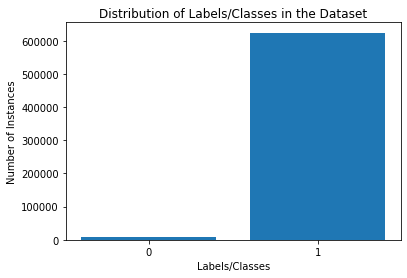

In [567]:
# A graph to show us how implance our data was
# Getting the no. of instances with Label 0
n_class_0 = df3[df3['CASE_STATUS']==0].shape[0]
# Getting the no. of instances with label 1
n_class_1 = df3[df3['CASE_STATUS']==1].shape[0]
# Bar Visualization of Class Distribution
import matplotlib.pyplot as plt # required library
x_2 = ['0', '1']
y_2 = np.array([n_class_0, n_class_1])
plt.bar(x_2, y_2)
plt.xlabel('Labels/Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Labels/Classes in the Dataset')

In [607]:
#start dealing with imbalance data, first we try undersampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df3.loc[:, df3.columns != 'CASE_STATUS'],df3["CASE_STATUS"])
print(sorted(Counter(y_resampled).items()))
y_resampled
X_resampled

[(0, 8554), (1, 8554)]


array([[2.38210000e+04, 1.32101278e-01, 5.36000000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 2.63900000e+03],
       [5.41511000e+05, 2.45402999e-01, 1.29700000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 2.63900000e+03],
       [3.33600000e+03, 1.81876370e-01, 1.49300000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 2.63900000e+03],
       ...,
       [5.23110000e+05, 4.47493652e-01, 4.73400000e+03, ...,
        0.00000000e+00, 2.00000000e+00, 2.63200000e+03],
       [5.41600000e+03, 2.55967579e-01, 5.23100000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 2.65000000e+03],
       [5.41330000e+05, 3.70000348e-01, 4.30700000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 2.63500000e+03]])

In [636]:
# here is the method of combination of over-under sampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(df2.loc[:, df2.columns != 'CASE_STATUS'],df2["CASE_STATUS"])
print(sorted(Counter(y_resampled).items()))

[(0, 599735), (1, 561135)]


In [637]:
# split into training, validation and test sets for balanced data

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size = 0.3,
                                                    random_state=123,
                                                    stratify=y_resampled)


In [638]:
# First try kNN(k nearest neighbour algorithm)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
# Checking the model's accuracy
#accuracy_score(y_test,y_pred)
# Checking the model's auc
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.949117327249702


0.949117327249702


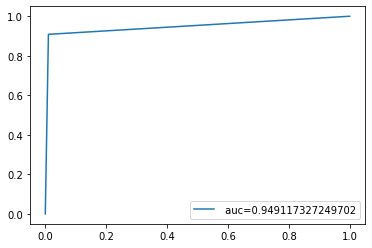

In [639]:
#auc graph
fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()



In [640]:
# applying cross validation for evaluating estimator performance
from sklearn.model_selection import cross_val_score 

scores = cross_val_score(knn_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')


print(scores)
print(scores.mean())

[0.95244072 0.99640469 0.9966552  0.99651784 0.99657394]
0.987718477811734


In [641]:
# feature scaling on kNN
# Importing MinMaxScaler and initializing it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
# Scaling down both train and test data set
X_train_minmax=min_max.fit_transform(X_train)
X_test_minmax=min_max.fit_transform(X_test)

In [642]:
# Fitting k-NN on our scaled data set
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_minmax,y_train)

y_pred = knn_model.predict(X_test_minmax)
# Checking the model's accuracy
#accuracy_score(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.5


In [643]:
# Random Forest for balanced data
from sklearn.ensemble import RandomForestClassifier     
from sklearn.metrics import roc_auc_score

forest_b = RandomForestClassifier(n_estimators=100, random_state=123)
forest_b.fit(X_train, y_train);

y_pred_b = forest_b.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_b))
auc = roc_auc_score(y_test, y_pred_b)
print(auc)

Accuracy: 0.9968759062886743
0.9969211991920811


In [654]:
# applying cross validation for evaluating estimator performance
from sklearn.model_selection import cross_val_score 

scores_2 = cross_val_score(forest_b, X_resampled, y_resampled, cv=10, scoring='accuracy')


print(scores_2)
print(scores_2.mean())

[0.73633795 0.99916443 0.99918166 0.9992075  0.9993281  0.99926778
 0.99911273 0.99917303 0.99919887 0.99937116]
0.9729343190055193


In [645]:
## Random Hyperparameter Grid
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 15)]

max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

max_features = ['auto','sqrt']

grid_param = {
    'n_estimators': n_estimators,
    'max_depth': max_depth, 
    'max_features': max_features,

}

# Random search of parameters
rf_random = RandomizedSearchCV(estimator = forest_b, 
                               param_distributions = grid_param, 
                               cv = 5, 
                               verbose=2, 
                               scoring = 'roc_auc',
                               random_state=123, 
                               n_jobs = -1)
# Fit the model
rf_random.fit(X_train_b, y_train_b)
# print results
print(rf_random.best_params_)

best_result = rf_random.best_score_
print(best_result)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.7min finished


{'n_estimators': 1678, 'max_features': 'auto', 'max_depth': 420}
0.800080657151538


0.9969211991920811


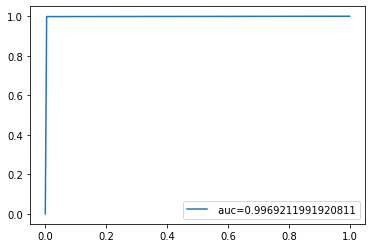

In [646]:
#auc graph for basic rf
fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred_b)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()



In [647]:
#final model try xgboost
import xgboost
gbm=xgboost.XGBClassifier(max_features='sqrt', subsample=0.8, random_state=10)

from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [10, 100]},
              {'learning_rate': [0.1, 0.01, 0.5]}]

grid_search = GridSearchCV(estimator = gbm, param_grid = parameters, scoring='roc_auc', cv = 3, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

import warnings
warnings.filterwarnings("ignore")

grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_

grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.8, verbosity=1)

In [648]:
gbm=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.8, verbosity=1).fit(X_train, y_train)

In [649]:
y_pred = gbm.predict(X_test)

In [650]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[163983  15938]
 [  4061 164279]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94    179921
           1       0.91      0.98      0.94    168340

    accuracy                           0.94    348261
   macro avg       0.94      0.94      0.94    348261
weighted avg       0.94      0.94      0.94    348261



In [651]:
# applying cross validation for evaluating estimator performance
from sklearn.model_selection import cross_val_score 

scores_3 = cross_val_score(gbm, X_resampled, y_resampled, cv=5, scoring='roc_auc')


print(scores_3)
print(scores_3.mean())

[0.90111058 0.98665716 0.98557906 0.98399573 0.98685953]
0.9688404086646404


In [652]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.9436464401210733

0.9436464401210733


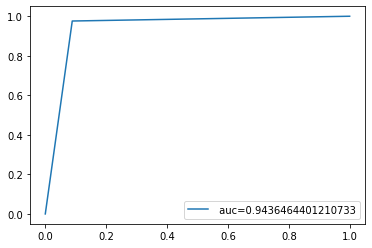

In [653]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()

# The ROC graph shows that 55% of the area is under the curve.